In [ ]:
# Prepare env
!pip install matplotlib python-sat                  

!mkdir -p labels-problem-examples
!cd labels-problem-examples && for i in `seq 1 6`; do wget https://github.com/NikitaSikalov/DataViz/raw/main/labels-problem-examples/hard$i.txt; done
!cd labels-problem-examples && wget https://github.com/NikitaSikalov/DataViz/raw/main/labels-problem-examples/bricks.txt
!cd labels-problem-examples && wget https://github.com/NikitaSikalov/DataViz/raw/main/labels-problem-examples/frame.txt

In [162]:
import typing as tp
import re

from dataclasses import dataclass, field

from pysat.solvers import Solver
from matplotlib import pyplot as plt
from matplotlib import patches, cm

In [230]:
def draw_labels(rects: tp.List["Rectangle"], points: tp.List["Point"]) -> None:
    """Scatter plot points and corresponding label rectangles
    :param rects: labels rects to draw
    :param points: correspoing points for drawing labels
    """
    title = "Label placement problem"
    fig, ax = plt.subplots(figsize=(12, 8))

    default_offset = 0.05
    
    max_x = max(map(lambda rect: rect.cords.x + rect.width, rects))
    max_y = max(map(lambda rect: rect.cords.y + rect.height, rects))
    
    min_x = min(map(lambda rect: rect.cords.x, rects))
    min_y = min(map(lambda rect: rect.cords.y, rects))

    delta_x = max_x - min_x
    delta_y = max_y - min_y

    max_x += delta_x * default_offset
    max_y += delta_y * default_offset
    min_x -= delta_x * default_offset
    min_y -= delta_y * default_offset

    ax.set_title(title)
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)

    ax.invert_yaxis()

    cmap = cm.get_cmap("hsv", len(rects))

    scatter_x = [p.cords.x for p in points]
    scatter_y = [p.cords.y for p in points]

    ax.scatter(scatter_x, scatter_y, marker='X', color='k', linewidth=2.5)
    
    patch_rects = [patches.Rectangle(
        xy=(rect.cords.x, rect.cords.y),
        width=rect.width, height=rect.height,
        facecolor=cmap(i), alpha=0.5
    ) for i, rect in enumerate(rects)]

    for patch_rect in patch_rects:
        ax.add_patch(patch_rect)

    plt.show()

In [125]:
class UnsolvedProblemError(Exception):
    pass


class EmptyRectsSet(Exception):
    pass


@dataclass
class Cords:
    x: int
    y: int


@dataclass
class Point:
    cords: Cords
    rects: tp.List["Rectangle"] = field(default_factory=list)

    def add_rect(self, rect: "Rectangle") -> None:
        self.rects.append(rect)


@dataclass
class Rectangle:
    """Rectangle data class
    Cords –– are coordinates of top-left angle of rectangle.
    Each rectagle has unqique id for SAT solver
    """
    id_: int
    cords: Cords
    width: int
    height: int
    point: Point
    implications: tp.Set[int] = field(default_factory=set)

    def __and__(self, rect: "Rectangle") -> bool:
        left_rect, right_rect = (self, rect) if self.cords.x < rect.cords.x else (rect, self)
        up_rect, down_rect = (self, rect) if self.cords.y < rect.cords.y else (rect, self)

        if (left_rect.cords.x <= right_rect.cords.x <= left_rect.cords.x + left_rect.width and
                up_rect.cords.y <= down_rect.cords.y <= up_rect.cords.y + up_rect.height):
            return True

        return False

    def add_implication(self, rect: "Rectangle") -> None:
        """Add implication for particular rectangle.
        For example if rectangle A can't be placed with current rectangle add -A.id_
        "-" before id_ means False in implication
        """
        self.implications.add(rect.id_)

In [126]:
class RectFactory:
    """Factory util for creating rectangles during parsing data"""
    def __init__(self, with_boundaries: bool = True, boundaires: tp.Tuple[int, int] = (500, 500)):
        self._rects: tp.List["Rectangle"] = []
        self._boundaries = boundaires
        self._with_boundaries = with_boundaries

    @property
    def rects(self):
        return self._rects

    def create_rect(self, point: Point, cords: Cords, width: int, height: int) -> tp.Optional["Rectangle"]:
        if self._with_boundaries and not self._is_rect_consistent_with_boundaries(cords=cords, width=width, height=height):
            return None

        next_id = len(self.rects) + 1
        rect = Rectangle(id_=next_id, cords=cords, width=width, height=height, point=point)
        self._rects.append(rect)

        return rect

    def _is_rect_consistent_with_boundaries(self, cords: Cords, width: int, height: int) -> bool:
        if cords.x < 0 or cords.y < 0:
            return False

        if cords.x + width > self._boundaries[0]:
            return False

        if cords.y + height > self._boundaries[1]:
            return False

        return True

In [139]:
class Parser:
    """Parse data with folowing format:
    <point x coord>,<point y coord>\t<width>,<height>\t<offset x>,<offset y> ...
    """
    def __init__(self):
        self._rect_factory = RectFactory(with_boundaries=True)
        self._points: tp.List[Point] = []

    @property
    def rects(self) -> tp.List[Rectangle]:
        return self._rect_factory.rects

    @property
    def points(self) -> tp.List[Point]:
        return self._points

    def __call__(self, data: tp.Iterable[str]) -> None:
        for row in data:
            if not row:
                continue

            point_coords, rect_sizes, offsets = re.split(r"\s+", row, maxsplit=2)
            point_x, point_y = self._parse_pair(point_coords)
            point = Point(Cords(point_x, point_y))

            width, height = self._parse_pair(rect_sizes)

            for offset_x, offset_y in (self._parse_pair(offset) for offset in offsets.split(" ")):
                rect_x = point_x - offset_x
                rect_y = point_y - offset_y

                rect = self._rect_factory.create_rect(point=point, cords=Cords(rect_x, rect_y), width=width, height=height)

                if rect is None:
                    continue

                point.add_rect(rect)

            if not point.rects:
                raise EmptyRectsSet(f"Not found consistent rects for point {point}")

            self.points.append(point)

    @staticmethod
    def _parse_pair(pair_str: str, separator=",") -> tp.Tuple[int, int]:
        x, y = tuple(map(int, pair_str.split(separator)))
        return (x, y)

In [140]:
class RectLayering:
    def __init__(self, rects: tp.List["Rectangle"], points: tp.List["Point"]):
        self._rects = rects
        self._points = points
        self._rects_dict: tp.Dict[int, "Rectangle"] = {rect.id_: rect for rect in rects}

    def __call__(self) -> tp.List["Rectangle"]:
        self._init_implications()

        with Solver(name="mc") as solver:
            # add clause that for each point at least one rect must be drawn
            # we use combination of add_atmost method and add_clause
            for point in self._points:
                rects_ids = [rect.id_ for rect in point.rects]
                solver.add_atmost(rects_ids, 1)
                solver.add_clause(rects_ids)

            # add implications clauses
            for rect in self._rects:
                for imp_id in rect.implications:
                    solver.add_clause([-rect.id_, -imp_id])

            # try to solve SAT problem
            if solver.solve():
                ids = solver.get_model()
                return [self._rects_dict[id_] for id_ in ids if id_ > 0]

            raise UnsolvedProblemError("Problem has not solution")

    def _init_implications(self) -> None:
        for rect1 in self._rects:
            for rect2 in self._rects:
                if rect1.point == rect2.point:
                    continue

                if rect1 & rect2:
                    rect1.add_implication(rect2)

In [141]:
def process_lables(rows: tp.Iterable[str]) -> None:
    parser = Parser()

    # firstly parse data rows
    parser(rows)

    # get data from parser
    all_rects = parser.rects
    all_points = parser.points

    # layer rectangles without crossings
    rects_layering = RectLayering(all_rects, all_points)
    result_rects = rects_layering()

    # check solution
    for rect1 in result_rects:
        for rect2 in result_rects:
            if rect1 == rect2:
                continue

            assert rect1 & rect2 is False, f"Found rects intersection for {rect1.id_} and {rect2.id_}"
    
    # after checking solution draw result
    draw_labels(result_rects, all_points)

### Layerings results

#### Simple examples

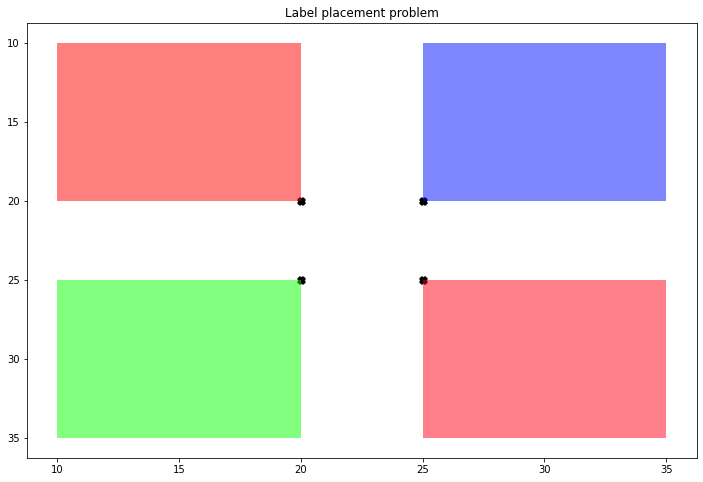

In [231]:
# read data from data string

custom_data = """
20,20   10,10   0,0 10,0 0,10 10,10
20,25	10,10	0,0 10,0 0,10 10,10
25,20	10,10	0,0 10,0 0,10 10,10
25,25	10,10	0,0 10,0 0,10 10,10
"""

process_lables(custom_data.split("\n"))

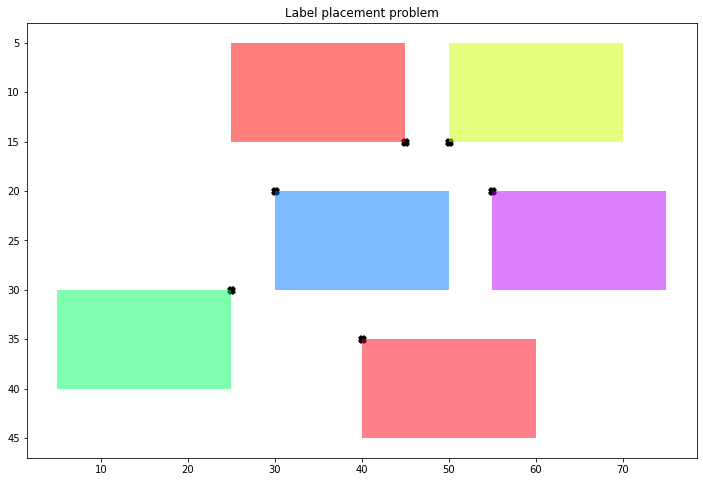

In [232]:
with open("./labels-problem-examples/bricks.txt", "r") as rows:
    process_lables(rows)

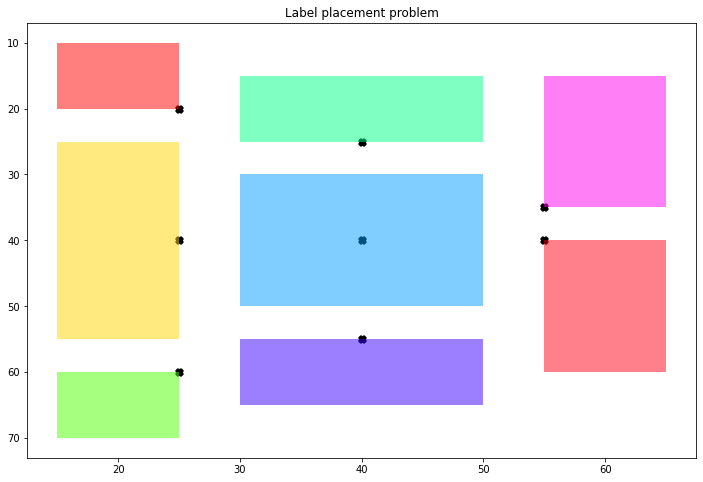

In [233]:
with open("./labels-problem-examples/frame.txt") as rows:
    process_lables(rows)

#### More complex examples

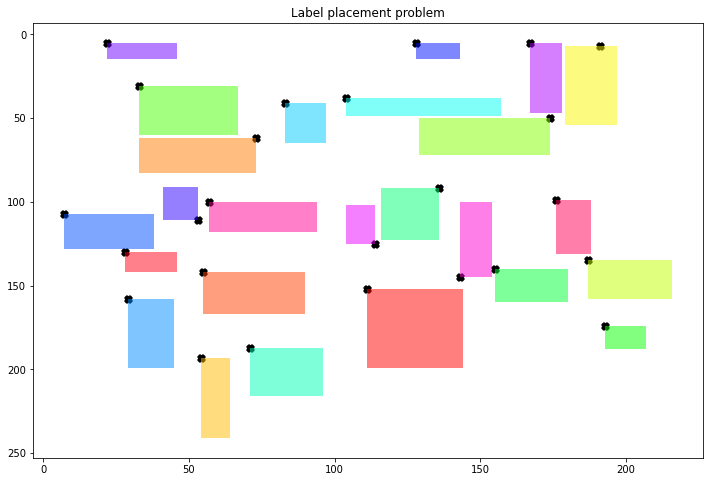

In [235]:
with open("./labels-problem-examples/hard1.txt") as rows:
    process_lables(rows)

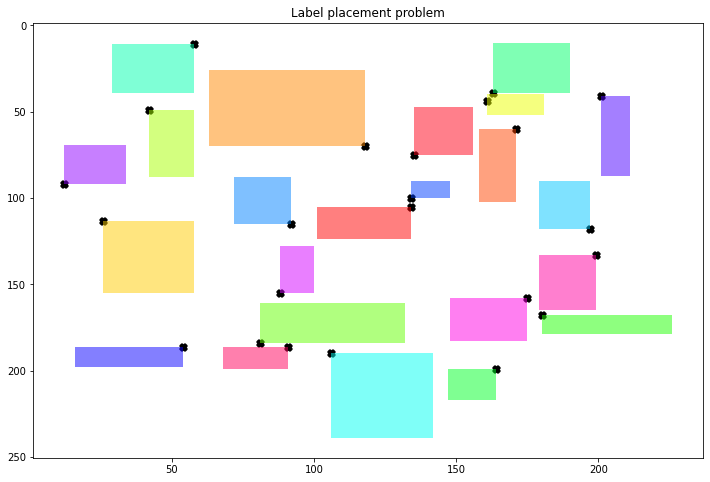

In [236]:
with open("./labels-problem-examples/hard2.txt") as rows:
    process_lables(rows)

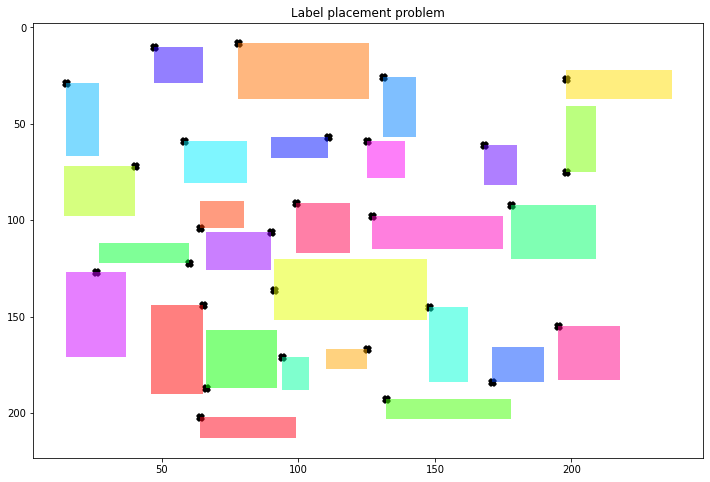

In [237]:
with open("./labels-problem-examples/hard3.txt") as rows:
    process_lables(rows)

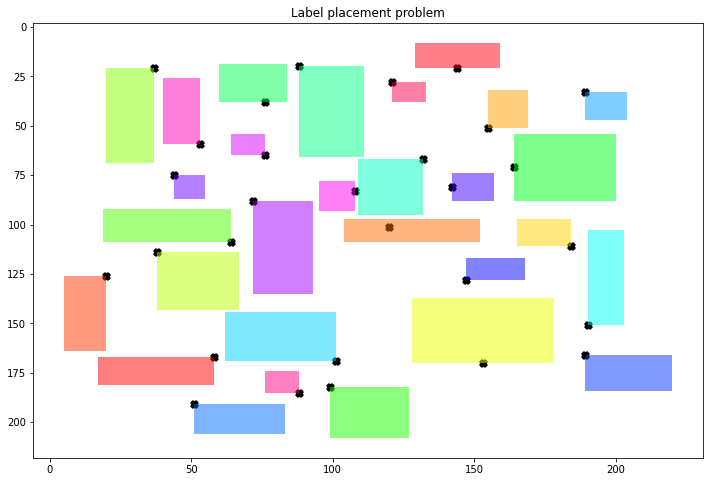

In [238]:
with open("./labels-problem-examples/hard4.txt") as rows:
    process_lables(rows)

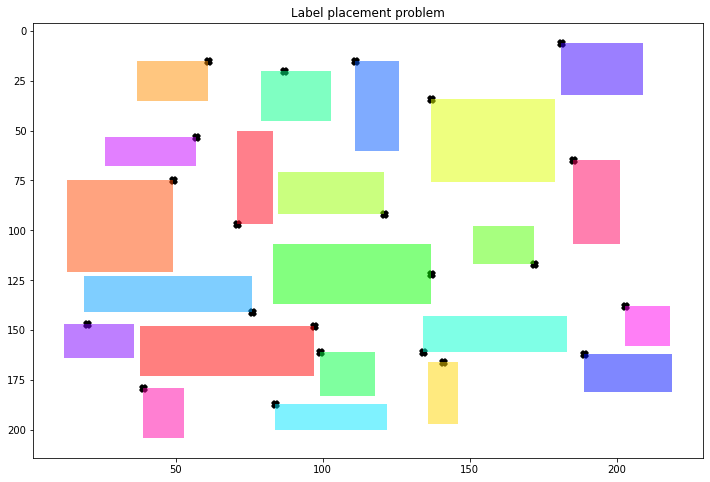

In [239]:
with open("./labels-problem-examples/hard5.txt") as rows:
    process_lables(rows)

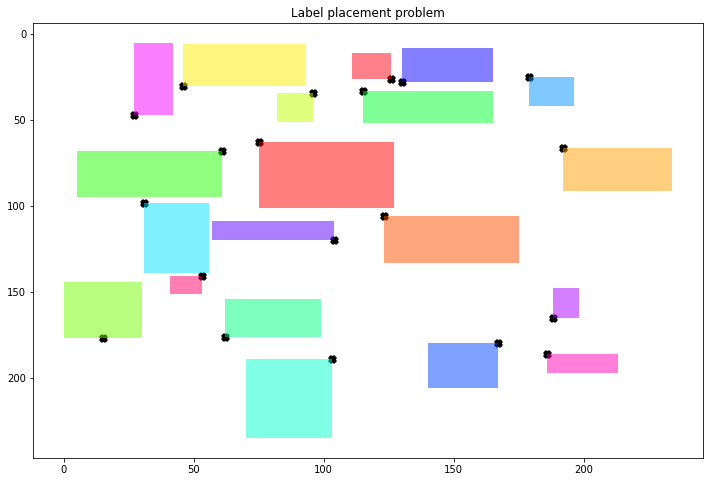

In [240]:
with open("./labels-problem-examples/hard6.txt") as rows:
    process_lables(rows)